In [ ]:
!pip install nbformat pandas numpy matplotlib seaborn

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import os

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Read all CSV files from the 'data' directory
data_dir = 'data'
files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Read all CSV files into DataFrames, keep track of source filename
dfs = []
for fname in files:
    fpath = os.path.join(data_dir, fname)
    df = pd.read_csv(fpath, sep=',')
    df['source_file'] = fname  # add column for original filename
    dfs.append(df)


df = pd.concat(dfs, ignore_index=True, sort=False)

# Display basic information about the merged dataset
print("Merged dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()


Merged dataset shape: (156570, 22)

Column names:
['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency', 'nrg_bal', 'Energy balance', 'siec', 'Standard international energy product classification (SIEC)', 'unit', 'Unit of measure', 'geo', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'Time', 'OBS_VALUE', 'Observation value', 'OBS_FLAG', 'Observation status (Flag) V2 structure', 'CONF_STATUS', 'Confidentiality status (flag)', 'source_file']

First few rows:


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag),source_file
0,dataflow,ESTAT:NRG_CB_OIL(1.0),"Supply, transformation and consumption of oil ...",A,Annual,FC_IND_CON_E,Final consumption - industry sector - construc...,O4000,Oil and petroleum products,THS_T,...,Albania,1990,NaN,0.0,NaN,NaN,NaN,NaN,NaN,eurostats_oil_consumption.csv
1,dataflow,ESTAT:NRG_CB_OIL(1.0),"Supply, transformation and consumption of oil ...",A,Annual,FC_IND_CON_E,Final consumption - industry sector - construc...,O4000,Oil and petroleum products,THS_T,...,Albania,1991,NaN,0.0,NaN,NaN,NaN,NaN,NaN,eurostats_oil_consumption.csv
2,dataflow,ESTAT:NRG_CB_OIL(1.0),"Supply, transformation and consumption of oil ...",A,Annual,FC_IND_CON_E,Final consumption - industry sector - construc...,O4000,Oil and petroleum products,THS_T,...,Albania,1992,NaN,0.0,NaN,NaN,NaN,NaN,NaN,eurostats_oil_consumption.csv
3,dataflow,ESTAT:NRG_CB_OIL(1.0),"Supply, transformation and consumption of oil ...",A,Annual,FC_IND_CON_E,Final consumption - industry sector - construc...,O4000,Oil and petroleum products,THS_T,...,Albania,1993,NaN,0.0,NaN,NaN,NaN,NaN,NaN,eurostats_oil_consumption.csv
4,dataflow,ESTAT:NRG_CB_OIL(1.0),"Supply, transformation and consumption of oil ...",A,Annual,FC_IND_CON_E,Final consumption - industry sector - construc...,O4000,Oil and petroleum products,THS_T,...,Albania,1994,NaN,0.0,NaN,NaN,NaN,NaN,NaN,eurostats_oil_consumption.csv


# 1. EDA

In [2]:
print("\nUnique countries:")
print(df['Geopolitical entity (reporting)'].unique())



Unique countries:
['Albania' 'Austria' 'Bosnia and Herzegovina' 'Belgium' 'Bulgaria'
 'Cyprus' 'Czechia' 'Germany' 'Denmark'
 'Euro area – 20 countries (2023-2025)' 'Estonia' 'Greece' 'Spain'
 'European Union - 27 countries (from 2020)' 'Finland' 'France' 'Georgia'
 'Croatia' 'Hungary' 'Ireland' 'Iceland' 'Italy' 'Liechtenstein'
 'Lithuania' 'Luxembourg' 'Latvia' 'Moldova' 'Montenegro'
 'North Macedonia' 'Malta' 'Netherlands' 'Norway' 'Poland' 'Portugal'
 'Romania' 'Serbia' 'Sweden' 'Slovenia' 'Slovakia' 'Türkiye' 'Ukraine'
 'United Kingdom' 'Kosovo*']


In [3]:
print("\nTime period range:")
print(f"From {df['TIME_PERIOD'].min()} to {df['TIME_PERIOD'].max()}")



Time period range:
From 1990 to 2024


In [4]:
df.columns

Index(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency',
       'nrg_bal', 'Energy balance', 'siec',
       'Standard international energy product classification (SIEC)', 'unit',
       'Unit of measure', 'geo', 'Geopolitical entity (reporting)',
       'TIME_PERIOD', 'Time', 'OBS_VALUE', 'Observation value', 'OBS_FLAG',
       'Observation status (Flag) V2 structure', 'CONF_STATUS',
       'Confidentiality status (flag)', 'source_file'],
      dtype='object')

## 1.1 Data Processing

In [5]:
df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')

# Filter out rows with missing values
df_clean = df[df['OBS_VALUE'].notna() & (df['OBS_VALUE'] > 0)].copy()

# Create a mapping function to categorize sectors
def map_to_sector(nrg_bal, energy_balance):
    """
    Map energy balance codes to main sectors:
    - Transport
    - Industry
    - Households
    - Electricity Generation
    """
    nrg_bal_str = str(nrg_bal).upper()
    energy_balance_str = str(energy_balance).upper()
    
    # Transport sector
    if 'TRANSPORT' in energy_balance_str or 'FC_TRA' in nrg_bal_str:
        return 'Transport'
    # Industry sector
    elif 'INDUSTRY' in energy_balance_str or 'FC_IND' in nrg_bal_str:
        return 'Industry'
    # Households sector
    elif 'HOUSEHOLD' in energy_balance_str or 'FC_OTH_HH' in nrg_bal_str or 'FC_OTH_CP' in nrg_bal_str:
        return 'Households'
    # Electricity generation
    elif 'ELECTRICITY' in energy_balance_str or 'TRANS' in energy_balance_str or 'POWER' in energy_balance_str:
        if 'TRANS' in nrg_bal_str or 'POWER' in energy_balance_str:
            return 'Electricity Generation'
    # Other/Unknown
    return 'Other'

# Apply sector mapping
df_clean['Sector'] = df_clean.apply(lambda x: map_to_sector(x['nrg_bal'], x['Energy balance']), axis=1)

# Display sector distribution
print("Sector distribution:")
print(df_clean['Sector'].value_counts())

Sector distribution:
Sector
Industry      41341
Transport     12274
Other          7407
Households     7052
Name: count, dtype: int64


In [6]:
def map_to_subsector(row):
    sub_sector = row['Energy balance'].split('-')[-2].strip()
    return sub_sector

df_clean['sub_sector'] = df_clean.apply(map_to_subsector, axis=1)

def map_to_fossil_fuel_type(row):
    fossil_fuel_type = row['source_file'].split('_')[1].strip()
    return fossil_fuel_type

df_clean['fossil_fuel_type'] = df_clean.apply(map_to_fossil_fuel_type, axis=1)

def map_to_consumption_type(row):
    consumption_type = row['Energy balance'].split(' - ')[-1].strip()
    return consumption_type

df_clean['consumption_type'] = df_clean.apply(map_to_consumption_type, axis=1)

In [7]:
df_clean = df_clean[['TIME_PERIOD', 'Sector', 'sub_sector', 'OBS_VALUE', 
'unit', 'Unit of measure', 
'Geopolitical entity (reporting)', 'geo', 'fossil_fuel_type', 'consumption_type']]

In [8]:
df_clean

,TIME_PERIOD,Sector,sub_sector,OBS_VALUE,unit,Unit of measure,Geopolitical entity (reporting),geo,fossil_fuel_type,consumption_type
9,1999,Industry,construction,6.0,THS_T,Thousand tonnes,Albania,AL,oil,energy use
10,2000,Industry,construction,7.0,THS_T,Thousand tonnes,Albania,AL,oil,energy use
11,2001,Industry,construction,8.0,THS_T,Thousand tonnes,Albania,AL,oil,energy use
12,2002,Industry,construction,3.0,THS_T,Thousand tonnes,Albania,AL,oil,energy use
13,2003,Industry,construction,7.0,THS_T,Thousand tonnes,Albania,AL,oil,energy use
...,...,...,...,...,...,...,...,...,...,...
155153,2016,Transport,road,1306.0,TJ_GCV,Terajoule (gross calorific value - GCV),Ukraine,UA,gas,energy use
155154,2017,Transport,road,1324.0,TJ_GCV,Terajoule (gross calorific value - GCV),Ukraine,UA,gas,energy use
155155,2018,Transport,road,1085.0,TJ_GCV,Terajoule (gross calorific value - GCV),Ukraine,UA,gas,energy use
155156,2019,Transport,road,936.0,TJ_GCV,Terajoule (gross calorific value - GCV),Ukraine,UA,gas,energy use


# 2. Analysis

> 2.1 QUESTION 1: Which sectors account for the largest share of fossil-fuel consumption in Europe, and how has their contribution shifted over time?


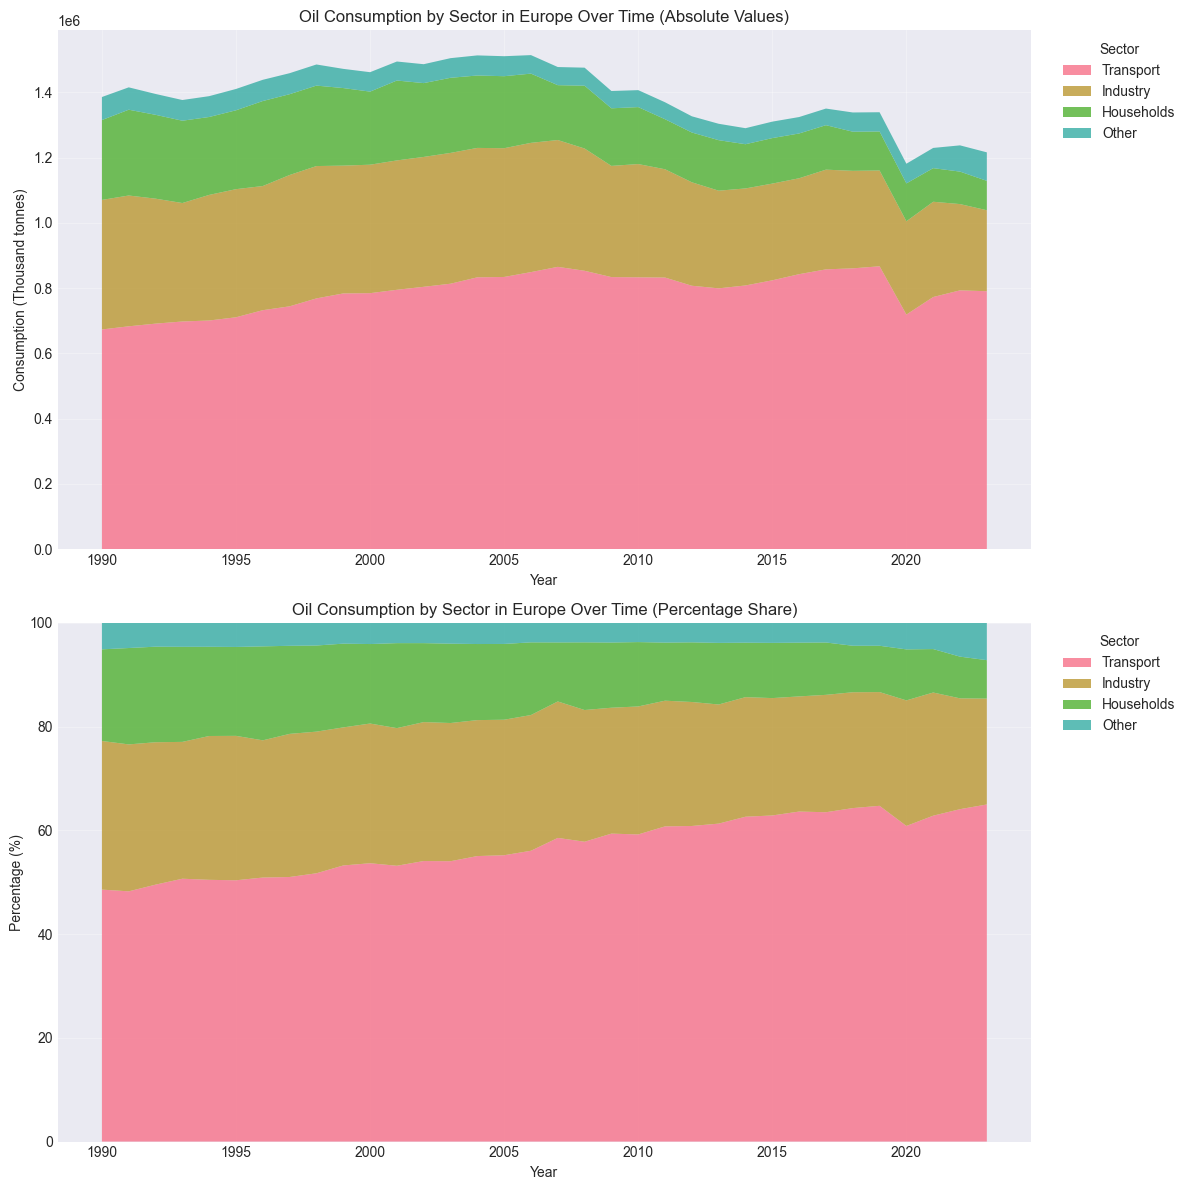

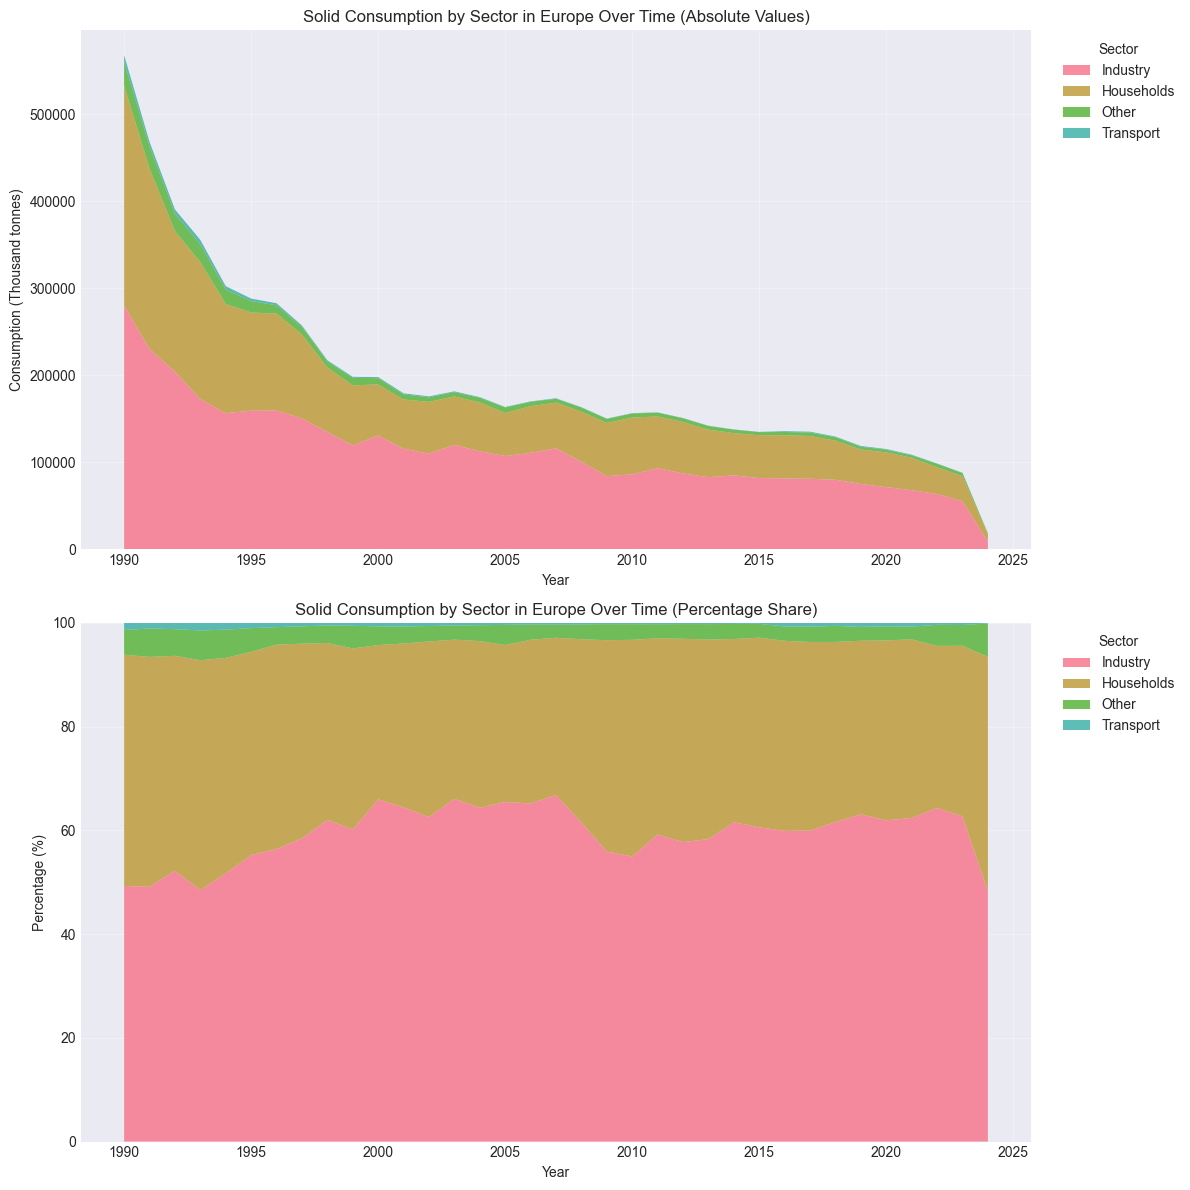

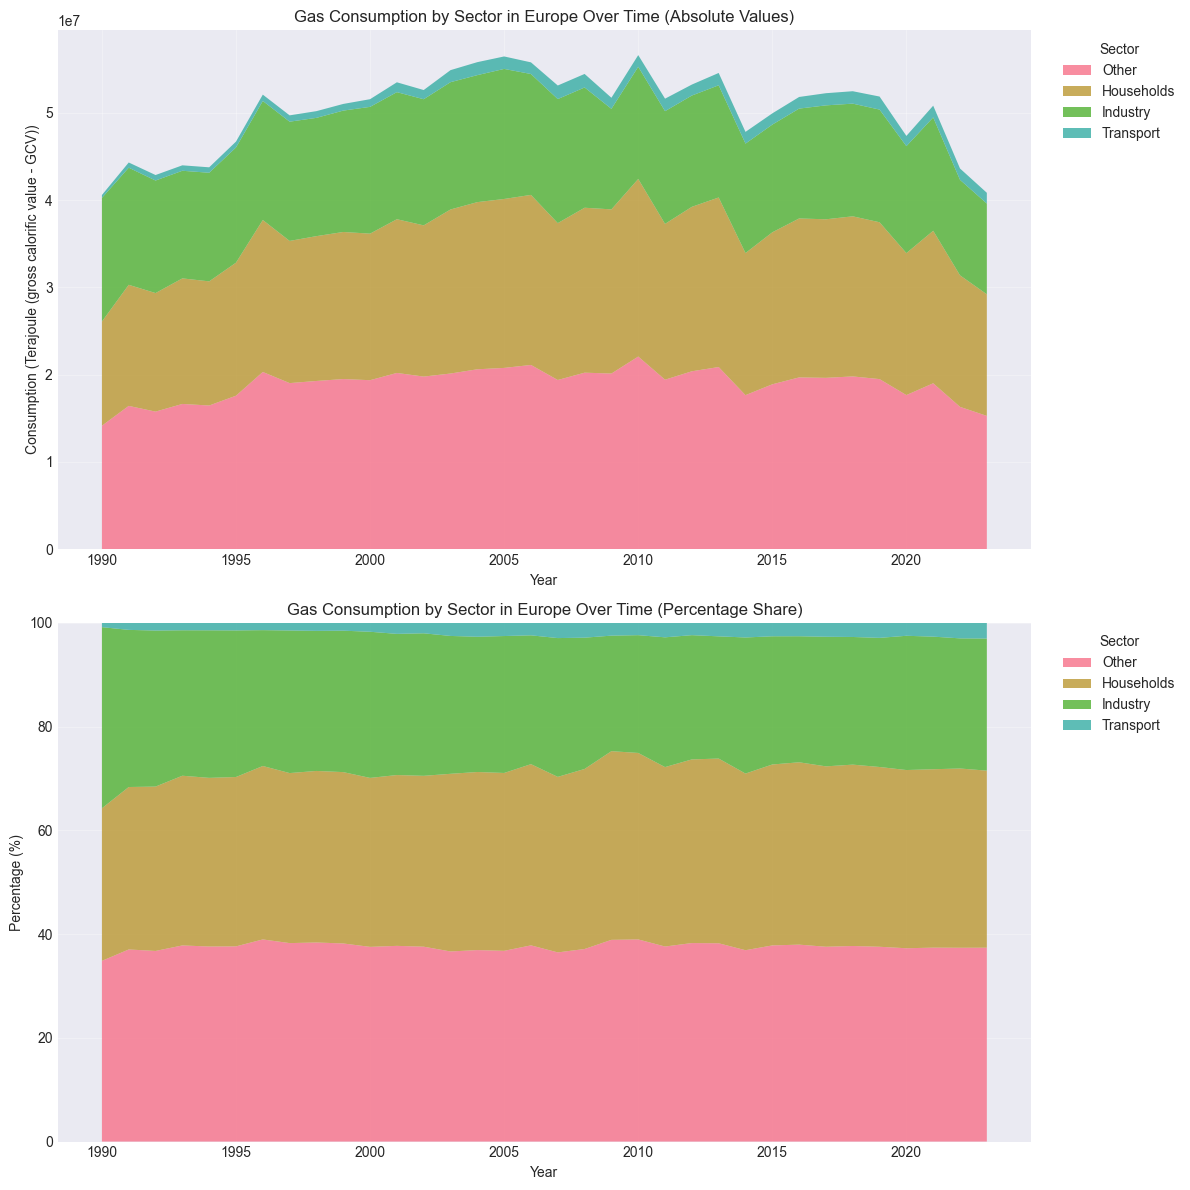

In [65]:
import matplotlib.pyplot as plt

# For each fossil_fuel_type, plot the stackplot of sector contributions over years
fossil_fuel_types = df_clean['fossil_fuel_type'].unique()

for fuel in fossil_fuel_types:
    subset = df_clean[df_clean['fossil_fuel_type'] == fuel]
    # Get unit information
    unit_info = subset['Unit of measure'].iloc[0] if not subset['Unit of measure'].empty else 'units'
    
    # Group and sum OBS_VALUE by year and sector
    sector_year_consumption = (
        subset.groupby(['TIME_PERIOD', 'Sector'])['OBS_VALUE']
        .sum()
        .reset_index()
    )
    # Pivot to wide format for stackplot
    pivot = sector_year_consumption.pivot_table(
        index='TIME_PERIOD', columns='Sector', values='OBS_VALUE', fill_value=0
    )
    # Order sectors by total consumption for readability
    sector_order = pivot.sum(axis=0).sort_values(ascending=False).index
    pivot = pivot[sector_order]
    # Ensure years are sorted numerically
    pivot = pivot.sort_index()
    
    # Create figure with two subplots: absolute and percentage
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot 1: Absolute values (stackplot)
    ax1.stackplot(
        pivot.index, 
        pivot.values.T, 
        labels=pivot.columns,
        alpha=0.8
    )
    ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title="Sector")
    ax1.set_title(f"{fuel.capitalize()} Consumption by Sector in Europe Over Time (Absolute Values)")
    ax1.set_xlabel("Year")
    ax1.set_ylabel(f"Consumption ({unit_info})")
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Percentage contribution
    pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
    ax2.stackplot(
        pivot_pct.index,
        pivot_pct.values.T,
        labels=pivot_pct.columns,
        alpha=0.8
    )
    ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title="Sector")
    ax2.set_title(f"{fuel.capitalize()} Consumption by Sector in Europe Over Time (Percentage Share)")
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Percentage (%)")
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [41]:
import plotly.express as px

selected_year = 2023
df_year = df_clean[df_clean['TIME_PERIOD'] == selected_year]

for fuel in df_year['fossil_fuel_type'].unique():
    df_fuel = df_year[df_year['fossil_fuel_type'] == fuel]
    agg = (
        df_fuel.groupby(['Sector', 'sub_sector'])['OBS_VALUE']
        .sum()
        .reset_index()
    )
    fig = px.sunburst(
        agg,
        path=['Sector', 'sub_sector'],
        values='OBS_VALUE',
        title=f"Sunburst Chart: {fuel.capitalize()} Consumption by Sector & Subsector ({selected_year})",
        color='Sector'
    )
    fig.show()

> Q2. How do Western vs. Eastern European countries differ in sectoral fossil-fuel consumption?

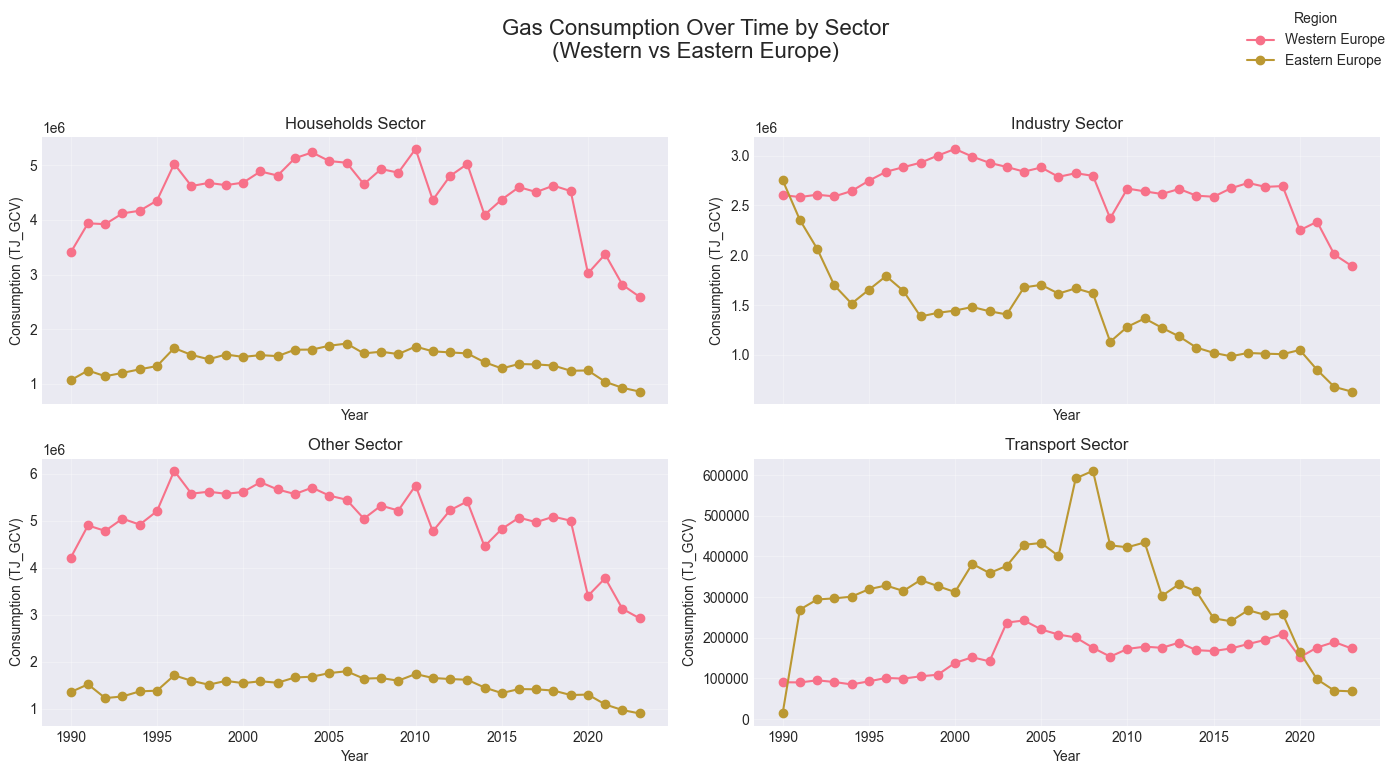

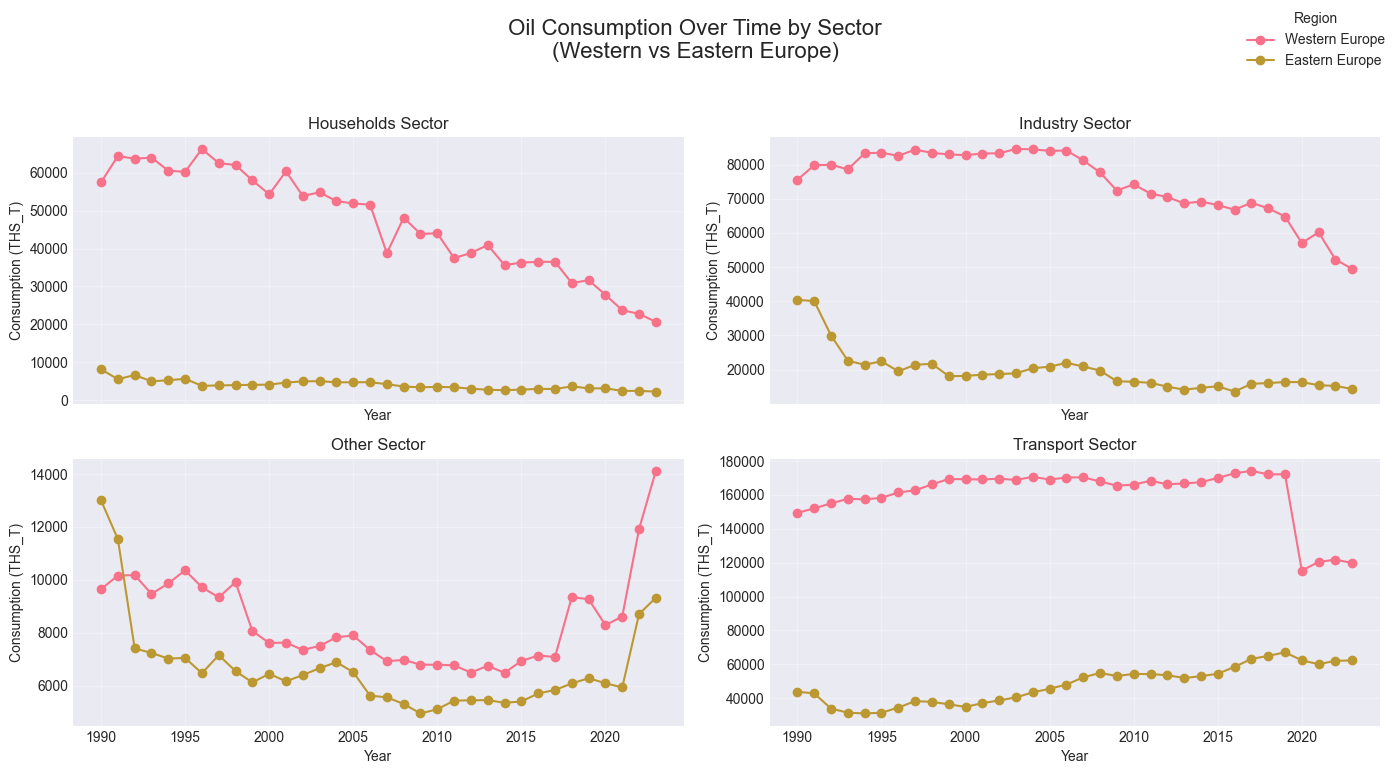

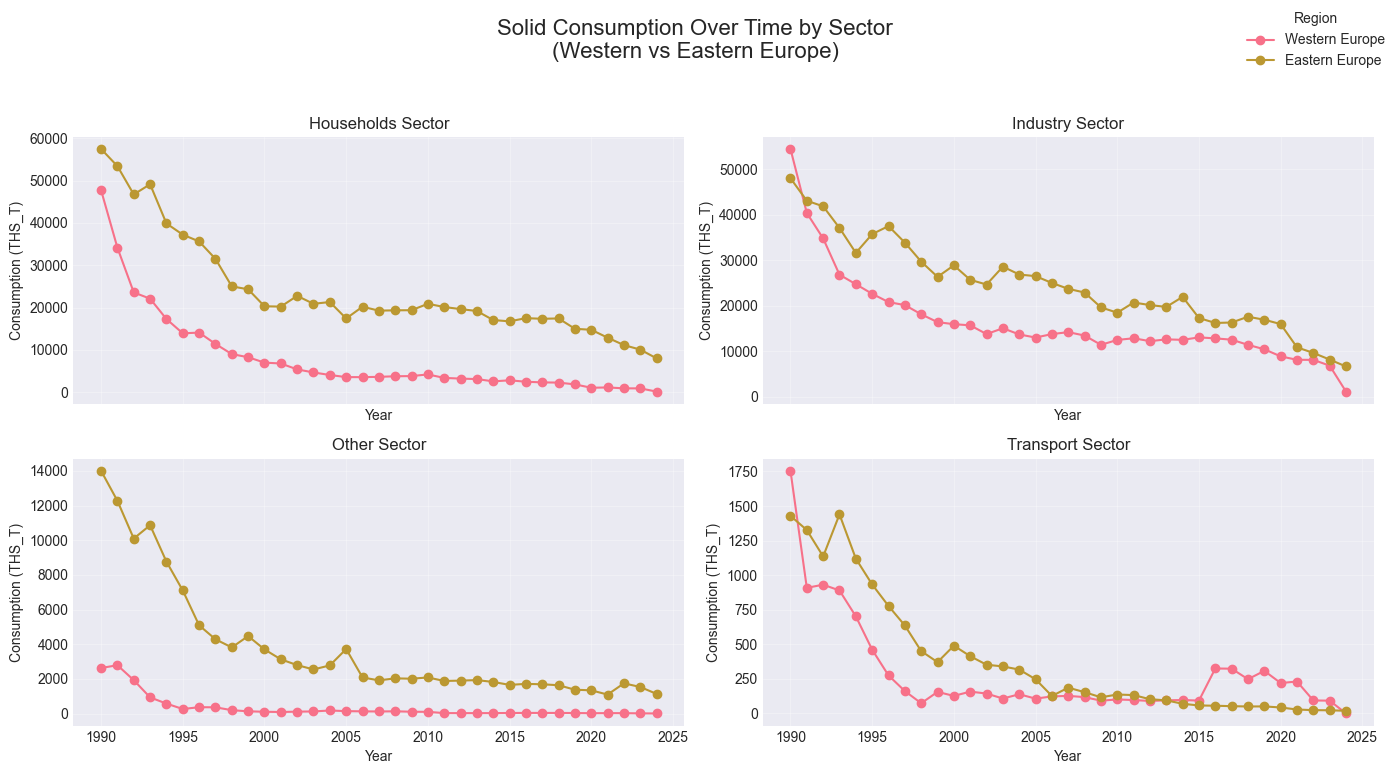

In [52]:
western_countries = [
    "Austria", "Belgium", "France", "Germany", "Netherlands", "Switzerland",
    "Luxembourg", "Ireland", "United Kingdom", "Monaco", "Liechtenstein"
]
eastern_countries = [
    "Albania", "Belarus", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Czechia",
    "Estonia", "Hungary", "Kosovo", "Latvia", "Lithuania", "Moldova", "North Macedonia", 
    "Poland", "Romania", "Russia", "Serbia", "Slovakia", "Slovenia", "Ukraine", "Montenegro"
]

def region_from_country(country):
    if country in western_countries:
        return "Western Europe"
    elif country in eastern_countries:
        return "Eastern Europe"
    else:
        return "Other"

df_clean['region'] = df_clean['Geopolitical entity (reporting)'].apply(region_from_country)

# Group by year, region, sector, fuel and sum consumption for time-series analysis
sector_region_year_agg = (
    df_clean[df_clean['region'].isin(['Western Europe', 'Eastern Europe'])]
    .groupby(['TIME_PERIOD', 'region', 'Sector', 'fossil_fuel_type'])['OBS_VALUE']
    .sum()
    .reset_index()
)

import matplotlib.pyplot as plt
import seaborn as sns
import math

# Get the most common unit for each fuel type
fuel_unit_map = (
    df_clean[df_clean['region'].isin(['Western Europe', 'Eastern Europe'])]
    .groupby('fossil_fuel_type')['unit']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else '')
    .to_dict()
)

for fuel in sector_region_year_agg['fossil_fuel_type'].unique():
    plot_data = sector_region_year_agg[sector_region_year_agg['fossil_fuel_type'] == fuel]
    sectors = sorted(plot_data['Sector'].unique())
    regions = ['Western Europe', 'Eastern Europe']
    fuel_unit = fuel_unit_map.get(fuel, "")

    n_sectors = len(sectors)
    ncols = 2
    nrows = math.ceil(n_sectors / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4*nrows), sharex=True)
    axes = axes.flatten() if n_sectors > 1 else [axes]

    handles_labels = dict()
    for idx, sector in enumerate(sectors):
        ax = axes[idx]
        for region in regions:
            series = plot_data[(plot_data['Sector'] == sector) & (plot_data['region'] == region)]
            series = series.sort_values('TIME_PERIOD')
            ax.plot(series['TIME_PERIOD'], series['OBS_VALUE'], marker='o', label=region)
        ax.set_title(f"{sector} Sector")
        ax.set_xlabel("Year")
        ax.set_ylabel(f"Consumption ({fuel_unit})")
        # Only collect legend handles from the first subplot
        if idx == 0:
            handles, labels = ax.get_legend_handles_labels()
            handles_labels = {"handles": handles, "labels": labels}
        ax.grid(True, alpha=0.3)
        # Remove individual subplot legends

    # If there are unused subplots, hide them
    for j in range(len(sectors), len(axes)):
        fig.delaxes(axes[j])

    # Place one legend in the figure as a whole
    if handles_labels:
        fig.legend(handles_labels["handles"], handles_labels["labels"], title="Region", loc='upper right')
    fig.suptitle(f"{fuel.capitalize()} Consumption Over Time by Sector\n(Western vs Eastern Europe)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


> Q3. Which sectors are driving the decline/growth of fossil fuel consumption in Europe?

In [20]:
df_clean

,TIME_PERIOD,Sector,sub_sector,OBS_VALUE,unit,Unit of measure,Geopolitical entity (reporting),geo,fossil_fuel_type,consumption_type,region
9,1999,Industry,construction,6.0,THS_T,Thousand tonnes,Albania,AL,oil,energy use,Eastern Europe
10,2000,Industry,construction,7.0,THS_T,Thousand tonnes,Albania,AL,oil,energy use,Eastern Europe
11,2001,Industry,construction,8.0,THS_T,Thousand tonnes,Albania,AL,oil,energy use,Eastern Europe
12,2002,Industry,construction,3.0,THS_T,Thousand tonnes,Albania,AL,oil,energy use,Eastern Europe
13,2003,Industry,construction,7.0,THS_T,Thousand tonnes,Albania,AL,oil,energy use,Eastern Europe
...,...,...,...,...,...,...,...,...,...,...,...
155153,2016,Transport,road,1306.0,TJ_GCV,Terajoule (gross calorific value - GCV),Ukraine,UA,gas,energy use,Eastern Europe
155154,2017,Transport,road,1324.0,TJ_GCV,Terajoule (gross calorific value - GCV),Ukraine,UA,gas,energy use,Eastern Europe
155155,2018,Transport,road,1085.0,TJ_GCV,Terajoule (gross calorific value - GCV),Ukraine,UA,gas,energy use,Eastern Europe
155156,2019,Transport,road,936.0,TJ_GCV,Terajoule (gross calorific value - GCV),Ukraine,UA,gas,energy use,Eastern Europe


In [24]:
europe_df['fossil_fuel_type'].unique()

array(['oil', 'solid', 'gas'], dtype=object)

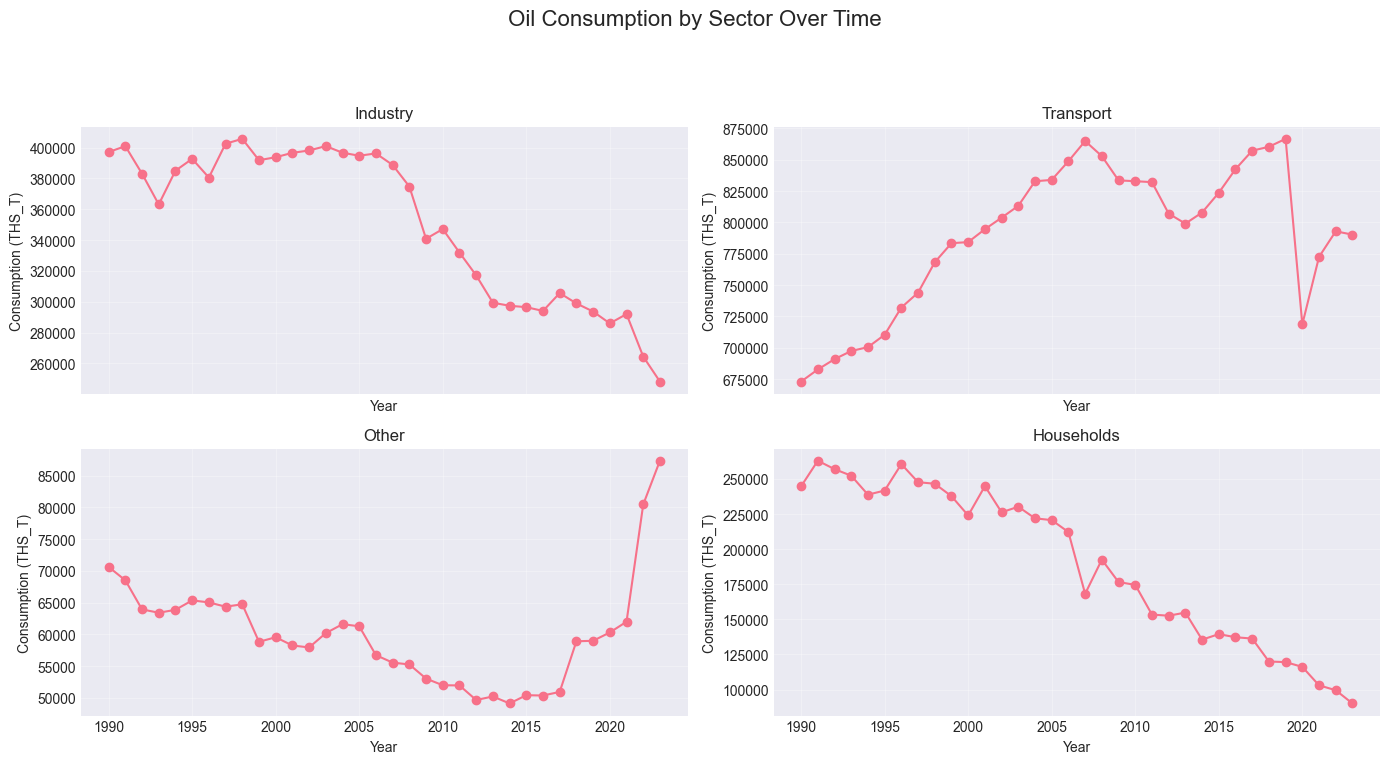

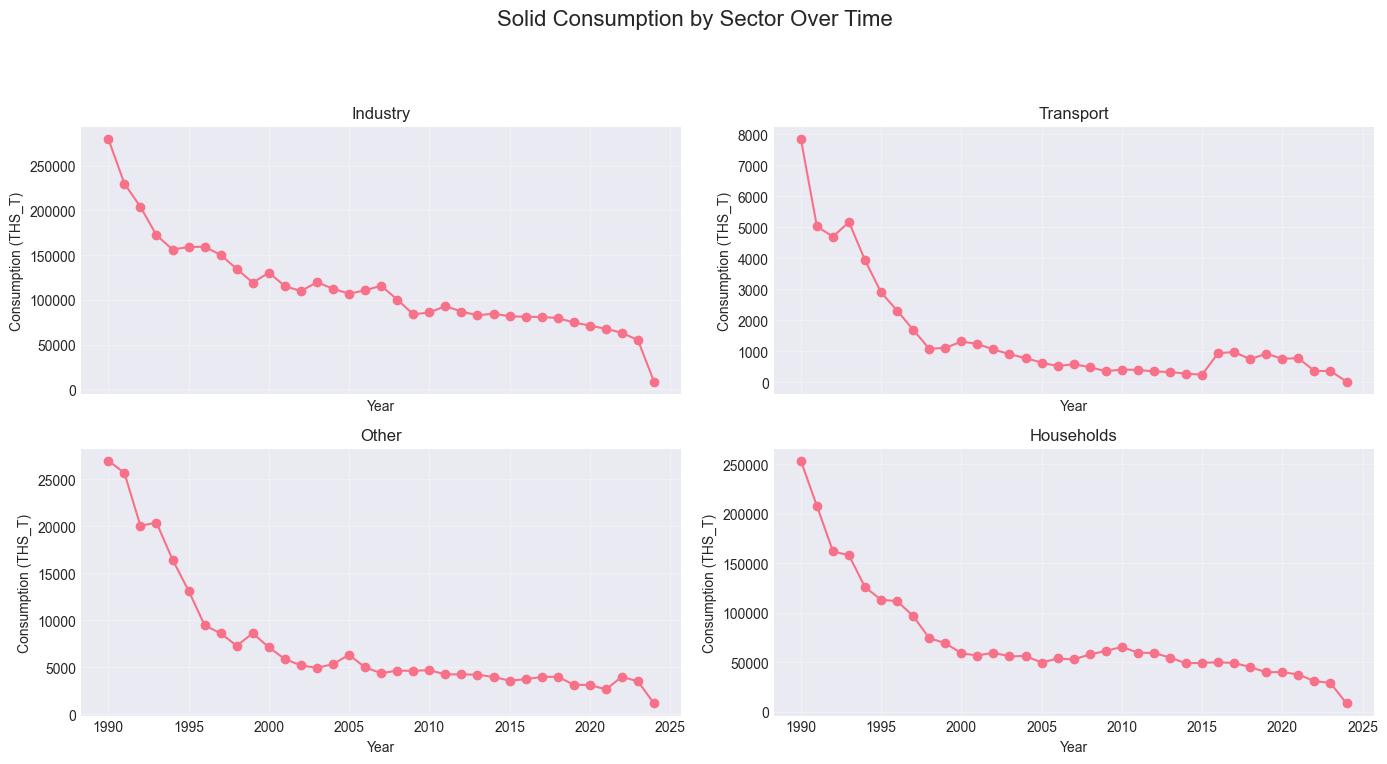

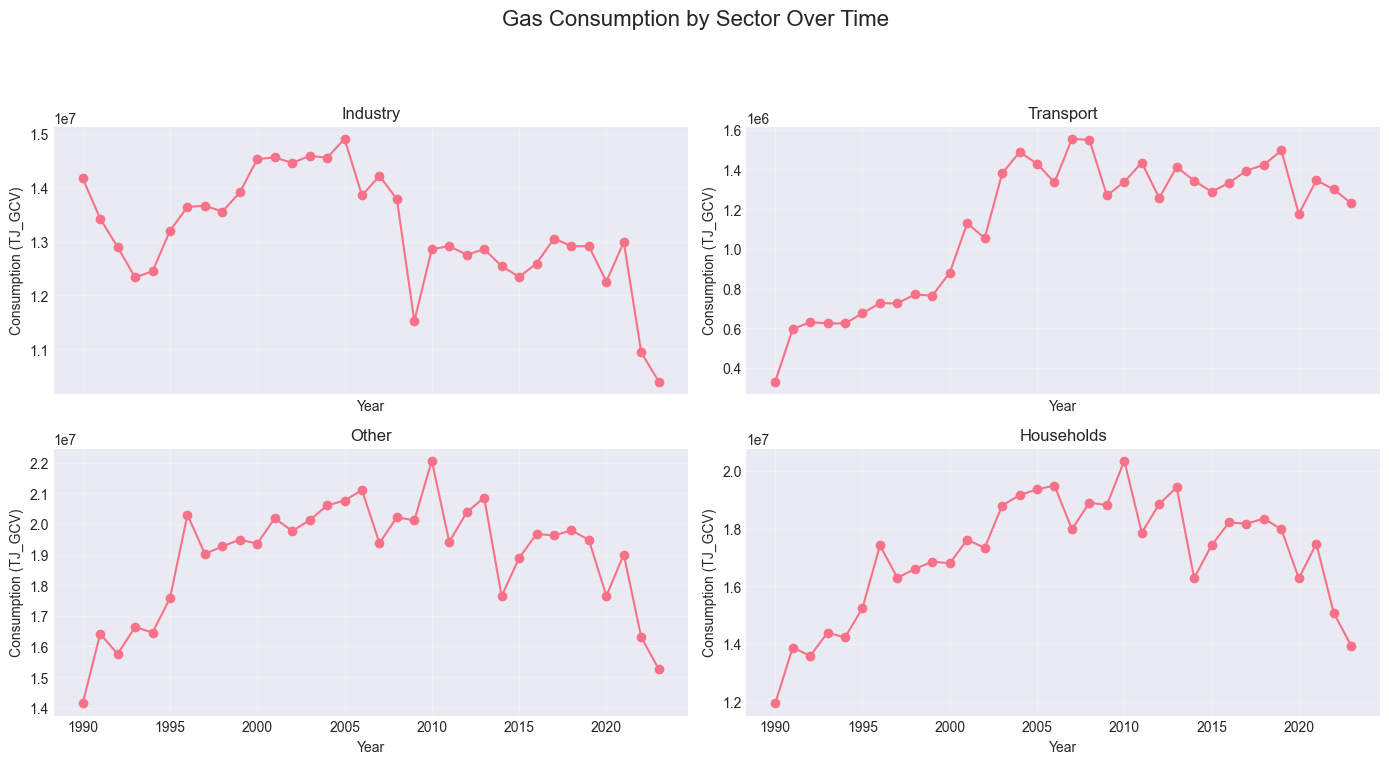

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Identify the major fossil fuel types present
main_fossil_fuels = df_clean['fossil_fuel_type'].unique()

# For each fuel type, plot the time series for all sectors in that type
for fuel in main_fossil_fuels:
    df_fuel = df_clean[df_clean['fossil_fuel_type'] == fuel]
    sectors = df_fuel['Sector'].unique()
    n_sectors = len(sectors)
    ncols = 2
    nrows = int(np.ceil(n_sectors / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), sharex=True)
    axes = axes.flatten() if n_sectors > 1 else [axes]
    years = np.sort(df_fuel['TIME_PERIOD'].unique())

    for idx, sector in enumerate(sectors):
        ax = axes[idx]
        sector_df = df_fuel[df_fuel['Sector'] == sector]
        # sum over region, sub_sector, etc. if required: here we just group by year for this sector/fuel
        sector_yearly = sector_df.groupby('TIME_PERIOD')['OBS_VALUE'].sum().reindex(years)
        ax.plot(years, sector_yearly, marker='o')
        ax.set_title(sector)
        ax.set_xlabel("Year")
        ax.set_ylabel(f"Consumption ({df_fuel['unit'].iloc[0]})")
        ax.grid(True, alpha=0.3)
    # Hide unused subplots, if any
    for j in range(len(sectors), len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(f"{fuel.capitalize()} Consumption by Sector Over Time\n", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
